<a href="https://colab.research.google.com/github/atharva-ketkar1/Retinal_Vessal_Segmentation/blob/main/retinal_vessal_seg_better_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Retinal_Vessal_Segmentation
#!git clone https://github.com/atharva-ketkar1/Retinal_Vessal_Segmentation.git
#%cd Retinal_Vessal_Segmentation


Mounted at /content/drive
/content/drive/MyDrive/Retinal_Vessal_Segmentation


In [ ]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Retinal_Vessal_Segmentation


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio

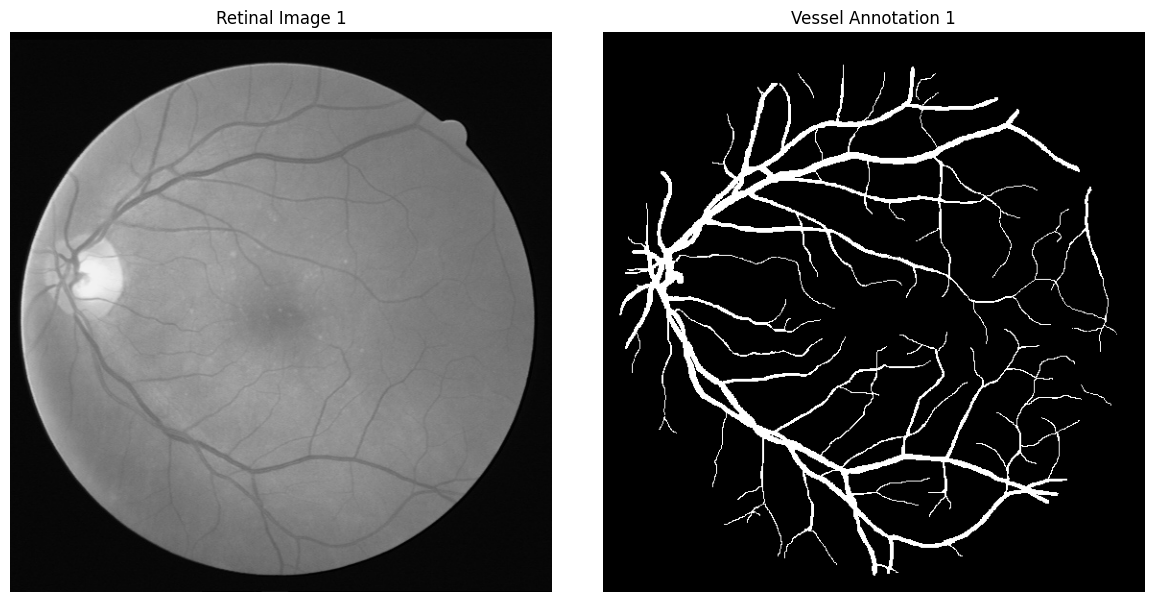

In [ ]:
# Make sure I can access the directory on Colab
image = cv2.imread('/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/images/21_training.tif', cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = imageio.imread('/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/1st_manual/21_manual1.gif')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Retinal Image 1")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Vessel Annotation 1")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Get size of image, the images aren't exactly the same dimensions, so I could use a 64x64 sliding window
print(image.shape, mask.shape)

(584, 565) (584, 565)


# Image Preprocessing

In [ ]:
'''
Split images into a 128x128 patches with a stride of 64.
Some of the patches for the mask will be just a black square,
so I will filter 75% of those squares out as well
'''
def split_image(image, mask, patch_size=128, stride=64):
    h, w = image.shape
    img_patches, mask_patches = [], []
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            #print(f"Processing patch at ({i}, {j})")
            img_patch = image[i:i+patch_size, j:j+patch_size]
            #img_patches.append(img_patch)
            mask_patch = mask[i:i+patch_size, j:j+patch_size]
            #mask_patches.append(mask_patch)
            if mask_patch.sum() > 0:
                img_patches.append(img_patch)
                mask_patches.append(mask_patch)
            elif np.random.rand() < 0.25:
                img_patches.append(img_patch)
                mask_patches.append(mask_patch)
    return img_patches, mask_patches

Generated 55 image patches and 55 mask patches


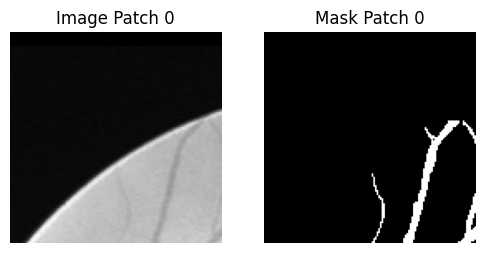

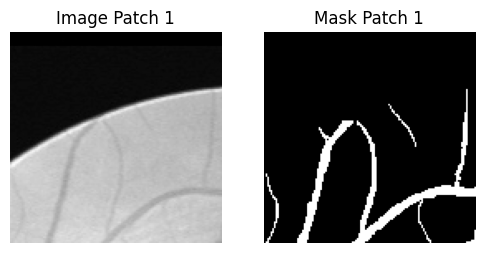

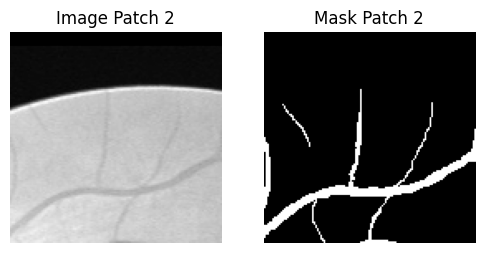

In [ ]:
# Test if the patch logic works with a single image

img_patches, mask_patches = split_image(image, mask, patch_size=128, stride=64)

print(f"Generated {len(img_patches)} image patches and {len(mask_patches)} mask patches")

# Print 3 images to make sure it is printing the patches correctly
for i in range(3):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_patches[i], cmap='gray')
    plt.title(f"Image Patch {i}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_patches[i], cmap='gray')
    plt.title(f"Mask Patch {i}")
    plt.axis("off")

    plt.show()


In [ ]:
'''
This works for one image, now I have to get the ~55 patches for all 20 images,
so it will return around 1100 total patches
'''
image_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/images/'
mask_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/training/1st_manual/'

all_images = sorted([x for x in os.listdir(image_dir) if x.endswith(".tif")])
all_masks = sorted([x for x in os.listdir(mask_dir) if x.endswith(".gif")])



all_img_patches, all_mask_patches = [],[]

for img_name, mask_name in zip(all_images, all_masks):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = imageio.imread(mask_path) / 255.0

    img_patches, mask_patches = split_image(image, mask)
    all_img_patches.extend(img_patches)
    all_mask_patches.extend(mask_patches)

print(f"Total patches: {len(all_img_patches)}")
print(f"Patch shape: {all_img_patches[0].shape}")

Total patches: 1118
Patch shape: (128, 128)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import numpy as np
import random

In [ ]:
'''
Create a class, and make sure to have the extra dimension in the dataset
so it works with the basic U-net model
'''
class PatchDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.clip(self.images[idx], 0, 1).astype(np.float32)
        mask = np.clip(self.masks[idx], 0, 1).astype(np.float32)

        img_tensor = torch.from_numpy(img).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        return img_tensor, mask_tensor

In [ ]:
# Basic Unet model with conv2d and dropout
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.2),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.2)
            )
        self.enc1 = conv_block(1, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)

        self.out_conv = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))


In [ ]:
# F1 Score
def f1_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

In [ ]:
def kfold(img_patches, mask_patches, folds=10, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X = list(img_patches)
    Y = list(mask_patches)

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_scores = []
    best_model_path = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model.pt'
    score_file_path = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model.txt'
    with open(score_file_path, 'r') as f:
        best_model = float(f.read().strip())

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{folds}")

        train_ds = PatchDataset([X[i] for i in train_idx], [Y[i] for i in train_idx])
        val_ds = PatchDataset([X[i] for i in val_idx], [Y[i] for i in val_idx])
        train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=8)

        model = UNet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.BCELoss()

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for x, y in train_dl:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = loss_fn(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if (epoch + 1) % 20 == 0:
              print(f"Epoch {epoch + 1} - Loss: {epoch_loss}")

        # Evaluation
        model.eval()
        val_dices = []
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                dice = f1_score(pred, y)
                val_dices.append(dice.item())

                img_np = x[0].cpu().squeeze().numpy()
                pred_np = pred[0].cpu().squeeze().numpy()
                mask_np = y[0].cpu().squeeze().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img_np, cmap='gray')
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(pred_np, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(mask_np, cmap='gray')
                plt.title("Actual Mask")
                plt.axis("off")

                plt.suptitle(f"Fold {fold + 1} Images")
                plt.show()

                break

        fold_score = np.mean(val_dices)
        if fold_score > best_model:
          best_model = fold_score
          torch.save(model.state_dict(), best_model_path)
          with open(score_file_path, 'w') as f:
            f.write(str(best_model))
          print(f"Saved best model to: {best_model_path} (F1 Score: {float(fold_score)})")
        print(f"Fold {fold + 1} F1 Score: {fold_score}")
        fold_scores.append(float(fold_score))

    print("\nFinal F1 Scores Range:")
    print(f"Mean F1 Score: {np.mean(fold_scores)} ± {np.std(fold_scores)}")



Fold 1/10
Epoch 20 - Loss: 14.920550167560577
Epoch 40 - Loss: 13.167142502963543
Epoch 60 - Loss: 12.108861833810806
Epoch 80 - Loss: 11.252167485654354
Epoch 100 - Loss: 10.656029336154461


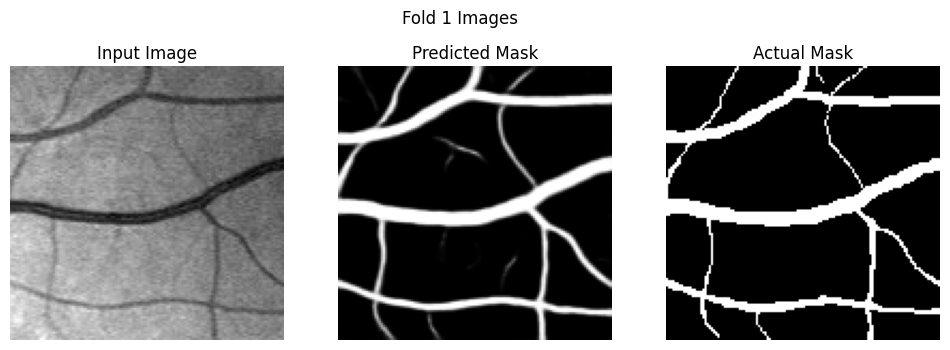

Fold 1 F1 Score: 0.8570473790168762

Fold 2/10
Epoch 20 - Loss: 14.88829142600298
Epoch 40 - Loss: 13.344129025936127
Epoch 60 - Loss: 12.170437671244144
Epoch 80 - Loss: 11.355879738926888
Epoch 100 - Loss: 10.765521422028542


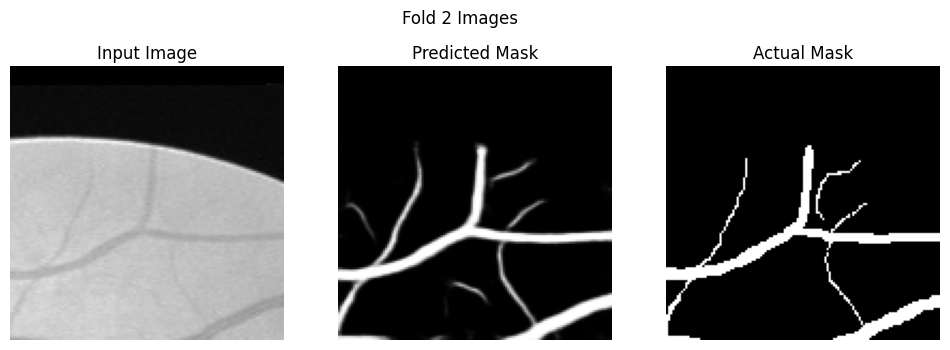

Fold 2 F1 Score: 0.8354790806770325

Fold 3/10
Epoch 20 - Loss: 15.071992091834545
Epoch 40 - Loss: 13.506023995578289
Epoch 60 - Loss: 12.270384766161442
Epoch 80 - Loss: 11.45833371207118
Epoch 100 - Loss: 10.810283120721579


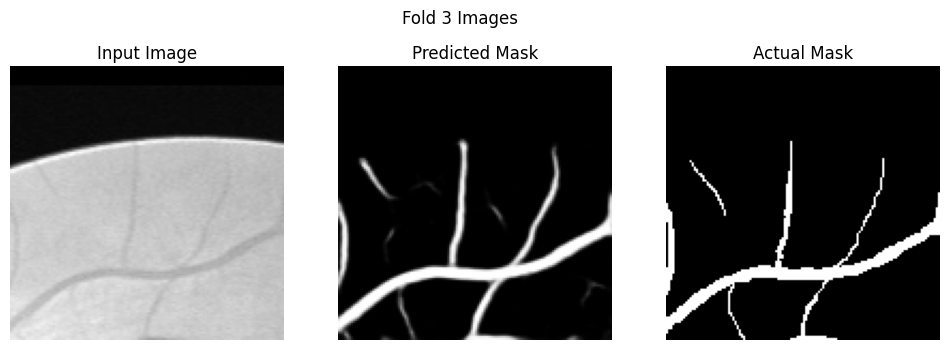

Fold 3 F1 Score: 0.8282665014266968

Fold 4/10
Epoch 20 - Loss: 15.650507256388664
Epoch 40 - Loss: 13.405724413692951
Epoch 60 - Loss: 12.603136271238327
Epoch 80 - Loss: 11.59640283882618
Epoch 100 - Loss: 11.00686751306057


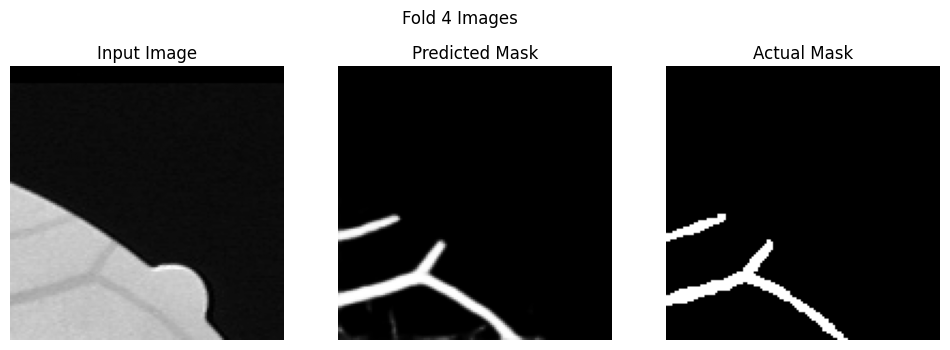

Fold 4 F1 Score: 0.8300045728683472

Fold 5/10
Epoch 20 - Loss: 15.070616312325
Epoch 40 - Loss: 13.508377604186535
Epoch 60 - Loss: 12.343643121421337
Epoch 80 - Loss: 11.438650134950876
Epoch 100 - Loss: 10.66331284493208


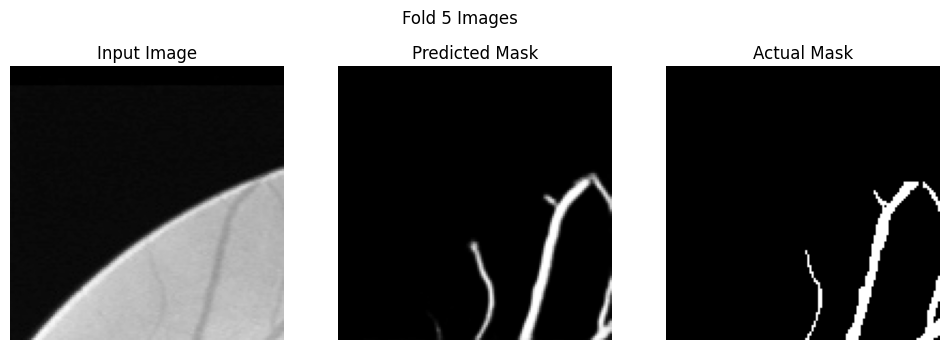

Fold 5 F1 Score: 0.8475428223609924

Fold 6/10
Epoch 20 - Loss: 15.472325667738914
Epoch 40 - Loss: 13.731372728943825
Epoch 60 - Loss: 12.709554068744183
Epoch 80 - Loss: 11.713792614638805
Epoch 100 - Loss: 11.142448529601097


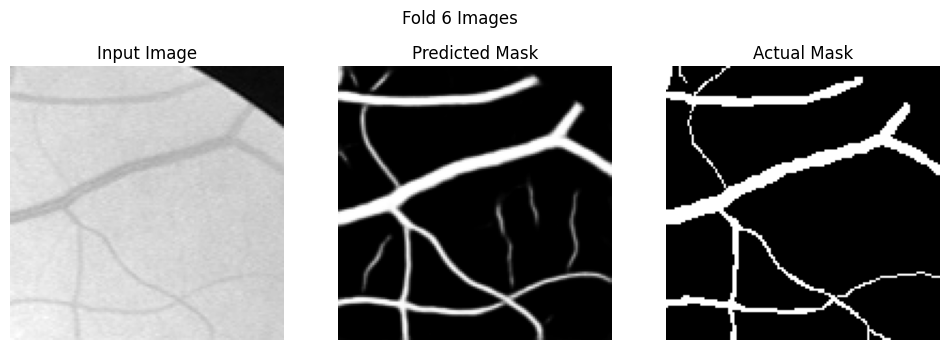

Fold 6 F1 Score: 0.859375

Fold 7/10
Epoch 20 - Loss: 15.229252316057682
Epoch 40 - Loss: 13.671406716108322
Epoch 60 - Loss: 12.640538610517979
Epoch 80 - Loss: 11.696144070476294
Epoch 100 - Loss: 11.237973555922508


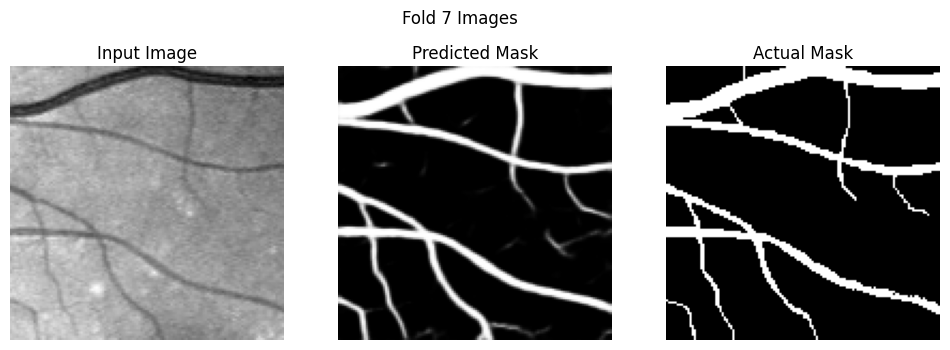

Fold 7 F1 Score: 0.8459680080413818

Fold 8/10
Epoch 20 - Loss: 15.311940513551235
Epoch 40 - Loss: 13.639752883464098
Epoch 60 - Loss: 12.371334232389927
Epoch 80 - Loss: 11.534986548125744
Epoch 100 - Loss: 10.945264175534248


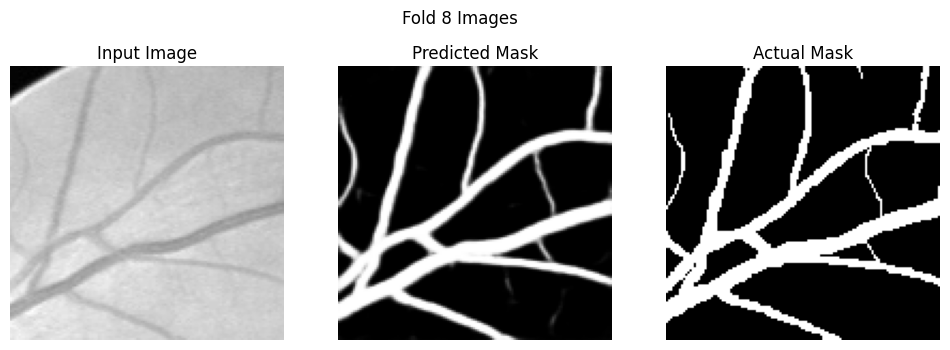

Fold 8 F1 Score: 0.8899387121200562

Fold 9/10
Epoch 20 - Loss: 15.648582078516483
Epoch 40 - Loss: 13.854442700743675
Epoch 60 - Loss: 12.754802130162716
Epoch 80 - Loss: 11.909980699419975
Epoch 100 - Loss: 11.315613776445389


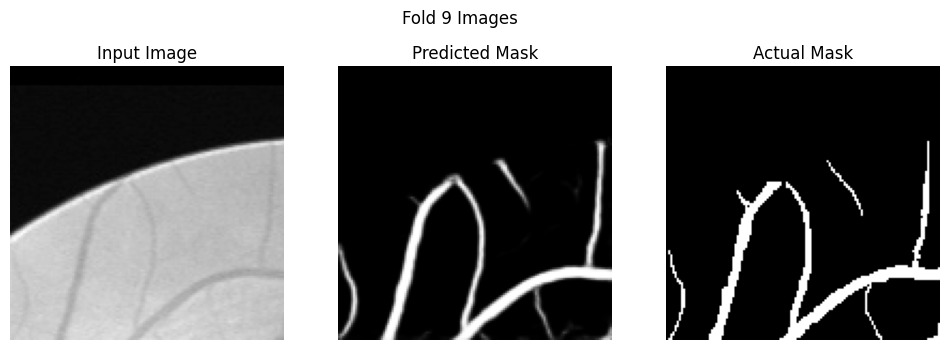

Fold 9 F1 Score: 0.8388954401016235

Fold 10/10
Epoch 20 - Loss: 15.075215481221676
Epoch 40 - Loss: 13.313678726553917
Epoch 60 - Loss: 12.269233204424381
Epoch 80 - Loss: 11.604964129626751
Epoch 100 - Loss: 10.982584215700626


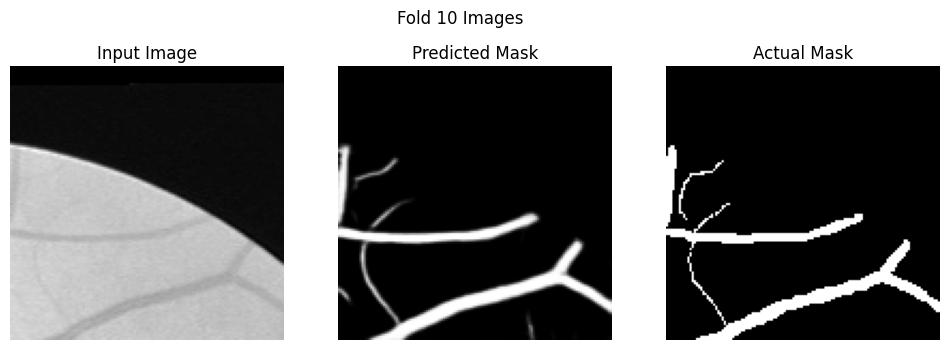

Fold 10 F1 Score: 0.8631181120872498

Final F1 Scores Range:
Mean F1 Score: 0.8495635628700257 ± 0.017695937638066674


In [ ]:
kfold(all_img_patches, all_mask_patches)

In [ ]:
# Try to predict a full image to see how it looks
def predict_full_image(model, full_image, patch_size=128, stride=64, device='cpu'):
    model.eval()
    h, w = full_image.shape
    output_mask = np.zeros((h, w))
    count_mask = np.zeros((h, w))
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = full_image[i:i+patch_size, j:j+patch_size]
            patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model(patch_tensor).cpu().squeeze().numpy()

            output_mask[i:i+patch_size, j:j+patch_size] += pred
            count_mask[i:i+patch_size, j:j+patch_size] += 1

    output_mask = output_mask / np.maximum(count_mask, 1e-7)
    return output_mask


In [ ]:
# Tested on 3 test images. The test images don't have any annotations, but by eyeballing it, the result it seems good

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Retinal_Vessal_Segmentation/models/best_model.pt'))
model.eval()

test_dir = '/content/drive/MyDrive/Retinal_Vessal_Segmentation/test/images/'
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith('.tif')])[:3]

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    full_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0

    predicted_mask = predict_full_image(model, full_image, device=device)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(full_image, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()